Question in my mind when running this test problem is that if the column density determines the emissivity of the CO or the depth and stopping length determines the emissivity seperately. To test this I am gonna read two cloudy runs one have high hden and low Rstop, the other have low hden but high Rstop, which their column density will be the same overall. I will check the resulting emissivity as a function of column density and resulting Lco.

In [1]:
import sys 
sys.path.append("/scratch/m/murray/dtolgay")
from tools import constants

import numpy as np 
import pandas as pd 

base_dir = "/home/m/murray/dtolgay/scratch/cloudy_runs/z_0/cr_1_CO87_CII_H_O3/cr_1_CO87_CII_H_O3_metallicity_above_minus_2"

import matplotlib.pyplot as plt 

# Functions  

In [2]:
def find_converged_run(cloudy_em_str: np.ndarray, threshold: float = 0) -> np.ndarray:
    """
    To use the coverged value, I will look at the radius values in the file. If radius decreases to initial radius and simulations
    ran one more time starting from the beginning then it means that in the first run it is not coverged and simulation was run again
    Second run gives the converged value. Use the second run.
    """

    index = 0
    for i in range(len(cloudy_em_str) - 1):
        if (cloudy_em_str[i][0] - cloudy_em_str[i + 1][0]) > threshold:
            index = i + 1

    cloudy_em_str = cloudy_em_str[index:]

    return cloudy_em_str

# Main

In [9]:
center_columns = ['log_metallicity', 'log_hden', 'log_turbulence', 'log_isrf', 'log_radius']
flux_columns = [
    "lya", # [erg s^-1 cm^-2]
    "ha", # [erg s^-1 cm^-2]
    "hb", # [erg s^-1 cm^-2]
    "co10", # [erg s^-1 cm^-2]
    "co21", # [erg s^-1 cm^-2]
    "co32", # [erg s^-1 cm^-2]
    "co43", # [erg s^-1 cm^-2]
    "co54", # [erg s^-1 cm^-2]
    "co65", # [erg s^-1 cm^-2]
    "co76", # [erg s^-1 cm^-2]
    "co87", # [erg s^-1 cm^-2]
    "13co", # [erg s^-1 cm^-2]
    "c2", # [erg s^-1 cm^-2]
    "o3_88", # [erg s^-1 cm^-2]
    "o3_5006", # [erg s^-1 cm^-2]
    "o3_4958", # [erg s^-1 cm^-2]    
]
# flux_columns = center_columns + flux_columns


# line_fluxes = pd.DataFrame(
#     np.loadtxt(f"{base_dir}/I_line_values_without_reversing.txt"),
#     columns = flux_columns
# )

line_fluxes = pd.read_csv(f"{base_dir}/F_line_values_without_reversing.csv")

In [11]:
for column in center_columns:
    print(f"{column}: {line_fluxes[column].unique()}")


log_metallicity: [-2.  -1.5 -1.  -0.5  0.   0.5  1. ]
log_hden: [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
log_turbulence: [-3. -2. -1.  0.  1.  2.  3.]
log_isrf: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]
log_radius: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


In [12]:

def read_emissivity_file(base_dir, file_props):
    
    emissivity_columns = [
        "depth",
        "lya",    # [erg/cm3/s]
        "ha",
        "hb",
        "co_10",
        "co_21",
        "co_32",
        "co_43",
        "co_54",
        "co_65",
        "co_76",
        "co_87",
        "13co",
        "c2",
        "o3_88", 
        "o3_5006", 
        "o3_4958",    
    ]    
    
    fname = f"hden{file_props['log_hden']:.5f}_metallicity{file_props['log_metallicity']:.5f}_turbulence{file_props['log_turbulence']:.5f}_isrf{file_props['log_isrf']:.5f}_radius{file_props['log_radius']:.5f}"
    
    emissivity_file = np.loadtxt(f"{base_dir}/{fname}/{fname}_em.str")
    emissivity_file = find_converged_run(emissivity_file)
    emissivity_file = pd.DataFrame(emissivity_file, columns=emissivity_columns)
    emissivity_file['column_density'] = emissivity_file['depth'] * (10**file_props['log_hden'] * constants.proton_mass * constants.kg2g) # g / cm2    
    
    return emissivity_file


In [13]:
file_props_1 = {
    "log_hden": 1,
    "log_metallicity": 1,
    "log_turbulence": 1,
    "log_isrf": -0.5,
    "log_radius": 3,
}
low_hden = read_emissivity_file(base_dir, file_props=file_props_1)


file_props_2 = {
    "log_hden": 3,
    "log_metallicity": 1,
    "log_turbulence": 1,
    "log_isrf": -0.5,
    "log_radius": 1,
}
high_hden = read_emissivity_file(base_dir, file_props=file_props_2)



emissivity_CO10_differentHden_sameColumnDensity.png saved!


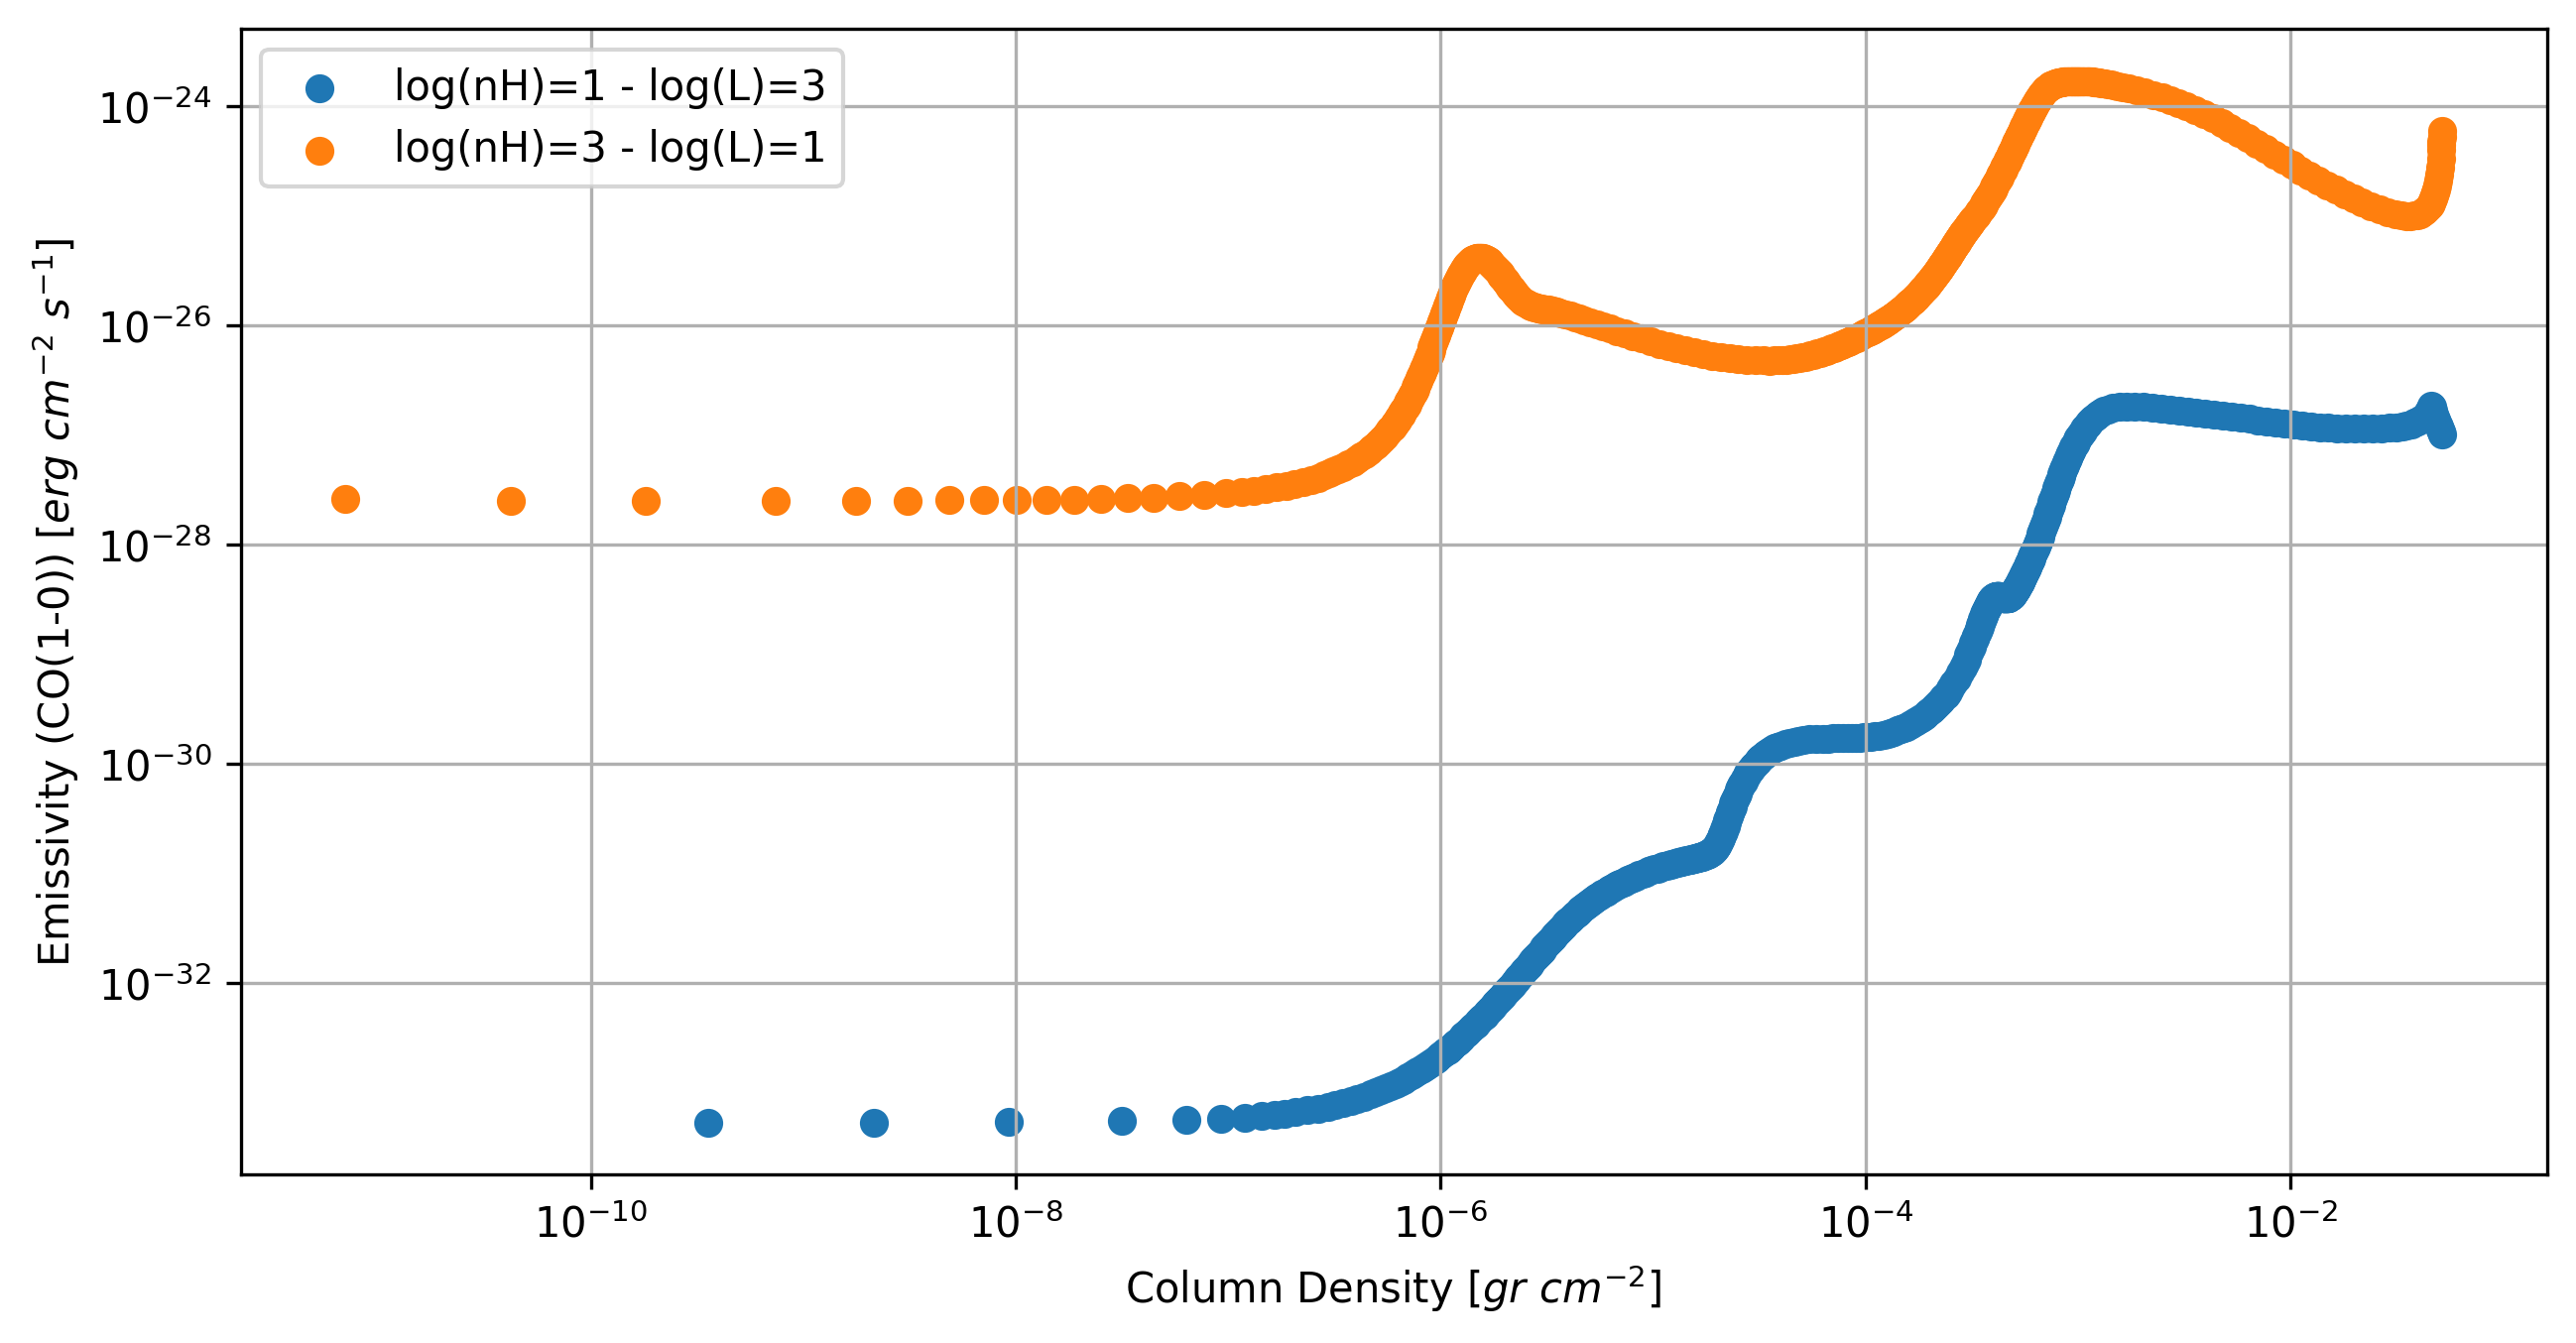

In [14]:
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(low_hden['column_density'], low_hden['co_10'], label="log(nH)=1 - log(L)=3")
plt.scatter(high_hden['column_density'], high_hden['co_10'], label="log(nH)=3 - log(L)=1")

plt.xlabel(r"Column Density [$gr$ $cm^{-2}$]")
plt.ylabel(r"Emissivity (CO(1-0)) [$erg$ $cm^{-2}$ $s^{-1}$]")

plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend(loc="upper left")

figure_name = "emissivity_CO10_differentHden_sameColumnDensity.png"
plt.savefig(figure_name)
print(f"{figure_name} saved!")

plt.show()

In [16]:
line_fluxes.columns

Index(['log_metallicity', 'log_hden', 'log_turbulence', 'log_isrf',
       'log_radius', 'ly_alpha', 'h_alpha', 'h_beta', 'co10', 'co21', 'co32',
       'co43', 'co54', 'co65', 'co76', 'co87', '13co', 'c2', 'o3_88',
       'o3_5006', 'o3_4958'],
      dtype='object')

In [18]:
# Print the calculated flux values
def find_indices_of_the_run(line_fluxes, file_props):
    index = np.where(
        (line_fluxes['log_hden'] == np.round(file_props['log_hden'], 1)) &
        (line_fluxes['log_metallicity'] == np.round(file_props['log_metallicity'], 1)) &
        (line_fluxes['log_turbulence'] == np.round(file_props['log_turbulence'], 1)) &
        (line_fluxes['log_isrf'] == np.round(file_props['log_isrf'], 1)) &
        (line_fluxes['log_radius'] == np.round(file_props['log_radius'], 1))
    )[0]
    
    return index

index1 = find_indices_of_the_run(line_fluxes, file_props=file_props_1)
index2 = find_indices_of_the_run(line_fluxes, file_props=file_props_2)

print(f"{line_fluxes.iloc[index1][center_columns + ['co10']]}")
print(f"{line_fluxes.iloc[index2][center_columns + ['co10']]}")


        log_metallicity  log_hden  log_turbulence  log_isrf  log_radius  \
106277              1.0       1.0             1.0      -0.5         3.0   

            co10  
106277  0.000004  
        log_metallicity  log_hden  log_turbulence  log_isrf  log_radius  \
108734              1.0       3.0             1.0      -0.5         1.0   

            co10  
108734  0.000008  


## Read in one galaxy and plot the distribution of Lco as a function of their density and column density

In [33]:
from tools import functions_readfiles as readfiles # type: ignore

galaxy_name = "m12i_res7100_md"
galaxy_type = "zoom_in"
redshift = "0.0"
directory = "voronoi_1e5"

# Read the interpolated file 
fdir = f"/scratch/m/murray/dtolgay/post_processing_fire_outputs/skirt/runs_hden_radius/{galaxy_type}/z{redshift}/{galaxy_name}/{directory}/line_emissions_RBFInterpolator_smoothingLength.txt"


gas_data, file_specific_columns = readfiles.read_interpolated_files_usingFilePath2(path = fdir, interpolation_type = "line_emissions")
gas_data['Nh'] = gas_data['hden'] * (gas_data['smoothing_length'] * constants.pc2cm)


# use only certain metallicities 
condition = (gas_data['metallicity'] > 1) & (gas_data['metallicity'] < 1.5)

gas_data_filtered = gas_data[condition].copy()

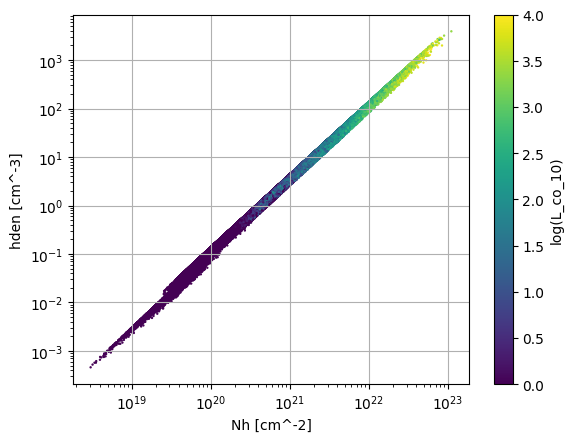

In [44]:

colorbar = np.log10(gas_data_filtered['L_co_10'])
plt.scatter(
    gas_data_filtered['Nh'],
    gas_data_filtered['hden'],
    c=colorbar, 
    cmap='viridis',
    vmin = 0,
    vmax = 4,
    s=0.5,
)
plt.colorbar(label='log(L_co_10)')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Nh [cm^-2]")
plt.ylabel("hden [cm^-3]")
plt.grid(True)


plt.show()


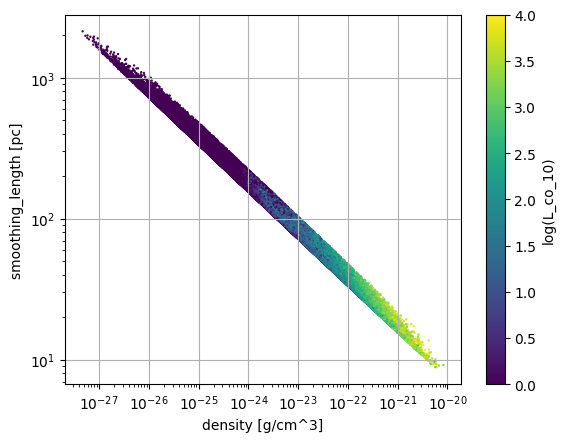

In [43]:

colorbar = np.log10(gas_data_filtered['L_co_10'])
plt.scatter(
    gas_data_filtered['density'],
    gas_data_filtered['smoothing_length'],
    c=colorbar, 
    cmap='viridis',
    vmin = 0,
    vmax = 4,
    s=0.5,
)
plt.colorbar(label='log(L_co_10)')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("density [g/cm^3]")
plt.ylabel("smoothing_length [pc]")
plt.grid(True)


plt.show()


In [ ]:

colorbar = np.log10(gas_data_filtered['L_co_10'])
plt.scatter(
    gas_data_filtered['Nh'],
    gas_data_filtered['smoothing_length'],
    c=colorbar, 
    cmap='viridis',
    vmin = 0,
    vmax = 4,
    s=0.5,
)
plt.colorbar(label='log(L_co_10)')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Nh [cm^-2]")
plt.ylabel("smoothing_length [pc]")
plt.grid(True)


plt.show()


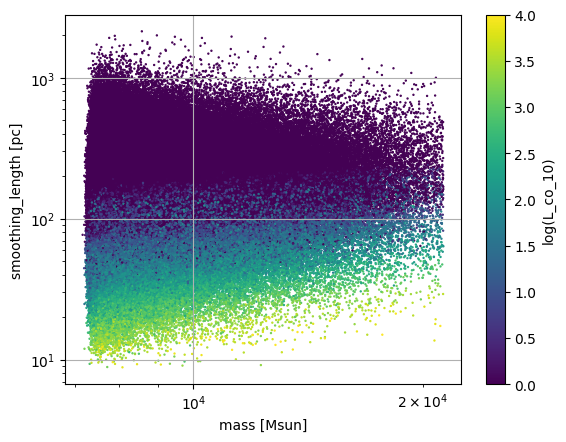

In [45]:

colorbar = np.log10(gas_data_filtered['L_co_10'])
plt.scatter(
    gas_data_filtered['mass'],
    gas_data_filtered['smoothing_length'],
    c=colorbar, 
    cmap='viridis',
    vmin = 0,
    vmax = 4,
    s=0.5,
)
plt.colorbar(label='log(L_co_10)')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("mass [Msun]")
plt.ylabel("smoothing_length [pc]")
plt.grid(True)


plt.show()
